In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

In [2]:
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [4]:
df = pd.read_csv("/kaggle/input/diabetes-prediction-dataset-csv/diabetes_prediction_dataset.csv")

In [5]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [6]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [8]:
df.describe().T.style.background_gradient(cmap='Greens')

,count,mean,std,min,25%,50%,75%,max
age,100000.000000,41.885856,22.516840,0.080000,24.000000,43.000000,60.000000,80.000000
hypertension,100000.000000,0.074850,0.263150,0.000000,0.000000,0.000000,0.000000,1.000000
heart_disease,100000.000000,0.039420,0.194593,0.000000,0.000000,0.000000,0.000000,1.000000
bmi,100000.000000,27.320767,6.636783,10.010000,23.630000,27.320000,29.580000,95.690000
HbA1c_level,100000.000000,5.527507,1.070672,3.500000,4.800000,5.800000,6.200000,9.000000
blood_glucose_level,100000.000000,138.058060,40.708136,80.000000,100.000000,140.000000,159.000000,300.000000
diabetes,100000.000000,0.085000,0.278883,0.000000,0.000000,0.000000,0.000000,1.000000


In [9]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [10]:
categorical_features = []
numerical_features = []

for col in df.columns:
    if col == "diabetes":
        continue  # do not treat target as a feature

    if df[col].nunique() > 6:
        numerical_features.append(col)
    else:
        categorical_features.append(col)

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)


Categorical Features: ['gender', 'hypertension', 'heart_disease', 'smoking_history']
Numerical Features: ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']


In [11]:
encoder = LabelEncoder()
df_encoded = df.copy()
cols_to_encode = ['gender', 'hypertension', 'heart_disease', 'smoking_history']
for col in cols_to_encode:
    df_encoded[col] = encoder.fit_transform(df_encoded[col])


In [12]:
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)

number of duplicate rows:  (3854, 9)


In [13]:
df = df.drop_duplicates()

In [14]:
df.diabetes.value_counts()

diabetes
0    87664
1     8482
Name: count, dtype: int64

In [15]:
df = df[df['gender'] != 'Other']

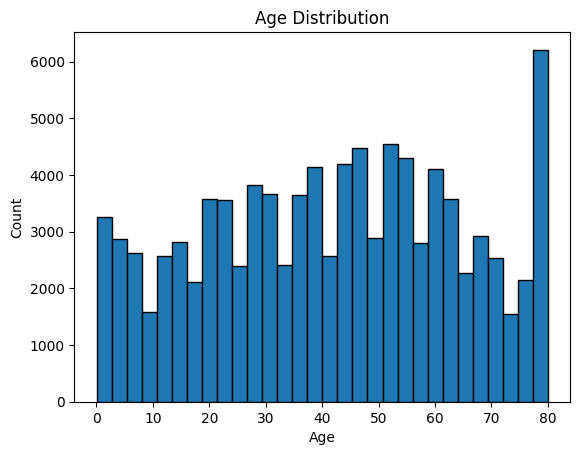

In [16]:
plt.hist(df['age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

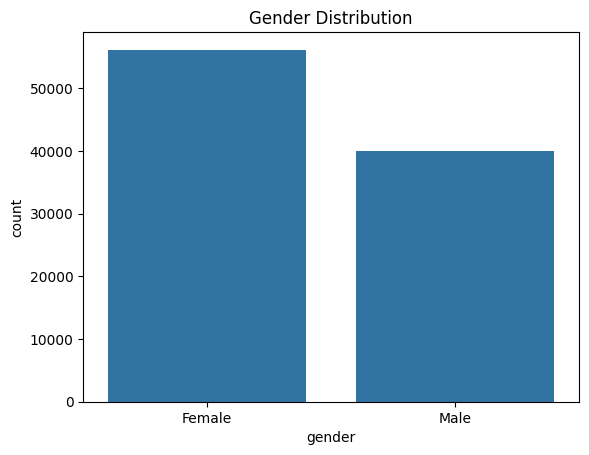

In [17]:
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.show()

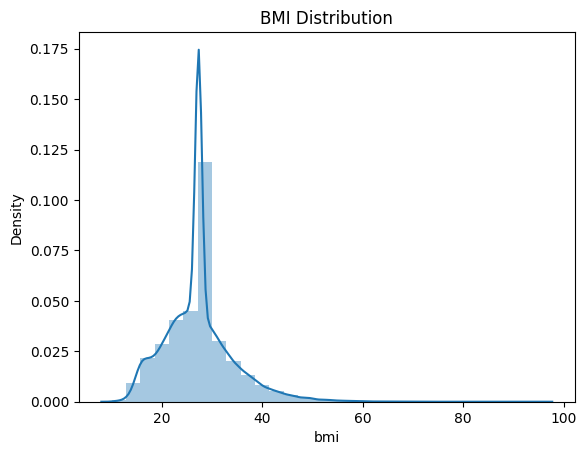

In [18]:
sns.distplot(df['bmi'], bins=30)
plt.title('BMI Distribution')
plt.show()

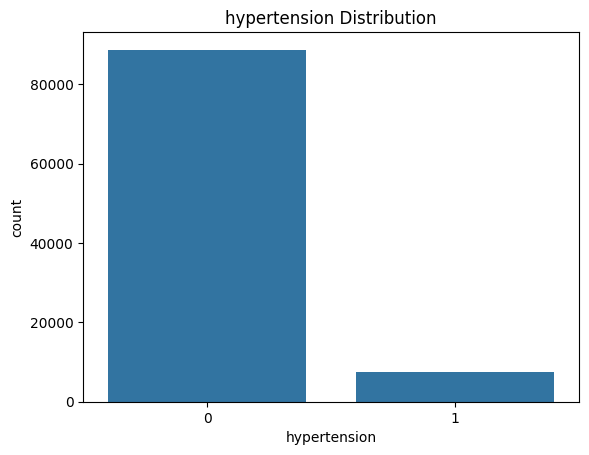

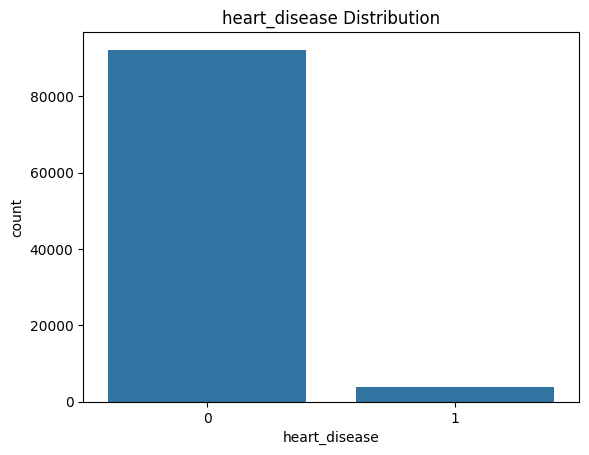

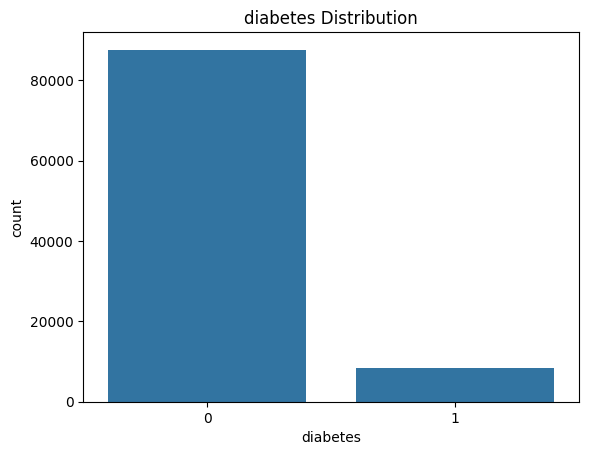

In [19]:
for col in ['hypertension', 'heart_disease', 'diabetes']:
    sns.countplot(x=col, data=df)
    plt.title(f'{col} Distribution')
    plt.show()

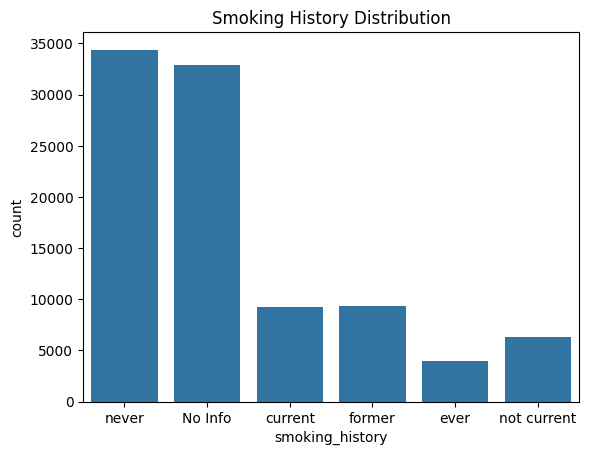

In [20]:
sns.countplot(x='smoking_history', data=df)
plt.title('Smoking History Distribution')
plt.show()

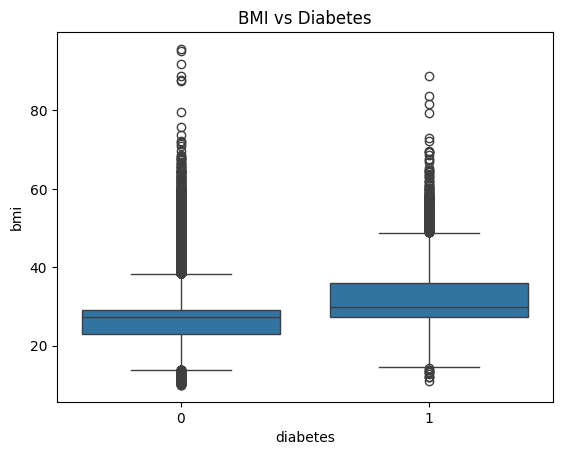

In [21]:
sns.boxplot(x='diabetes', y='bmi', data=df)
plt.title('BMI vs Diabetes')
plt.show()

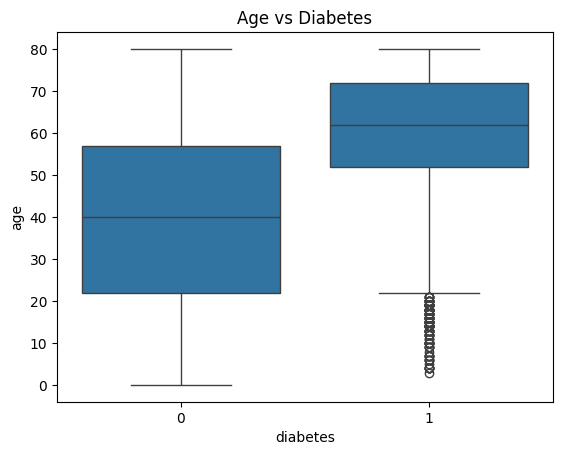

In [22]:
sns.boxplot(x='diabetes', y='age', data=df)
plt.title('Age vs Diabetes')
plt.show()

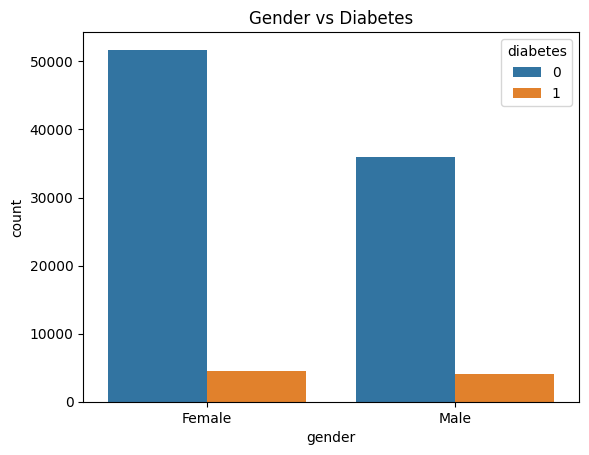

In [23]:
sns.countplot(x='gender', hue='diabetes', data=df)
plt.title('Gender vs Diabetes')
plt.show()

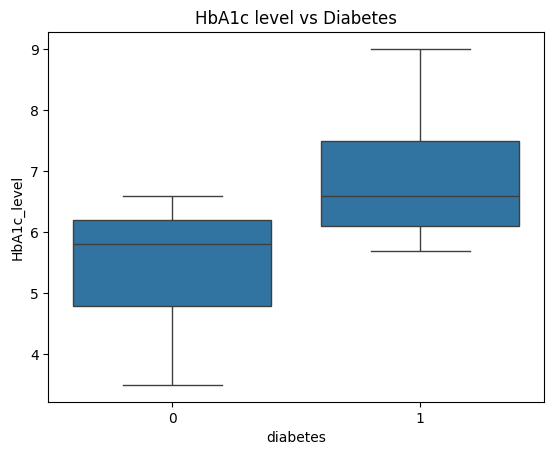

In [24]:
sns.boxplot(x='diabetes', y='HbA1c_level', data=df)
plt.title('HbA1c level vs Diabetes')
plt.show()


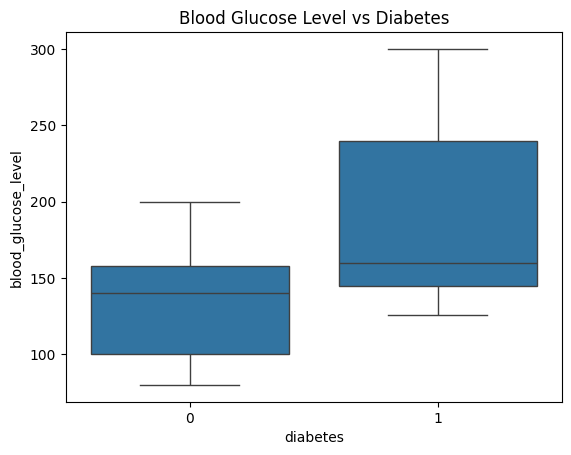

In [25]:
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df)
plt.title('Blood Glucose Level vs Diabetes')
plt.show()

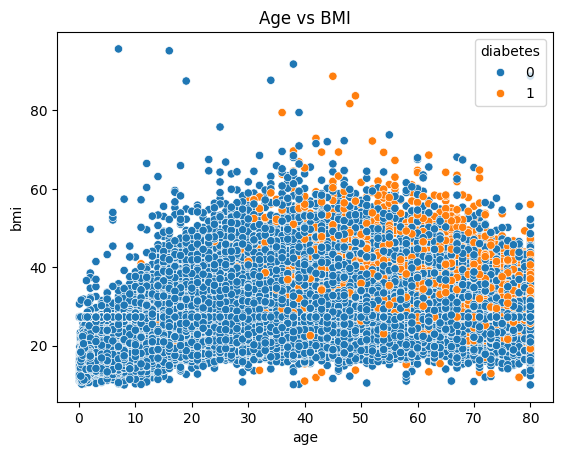

In [26]:
sns.scatterplot(x='age', y='bmi', hue='diabetes', data=df)
plt.title('Age vs BMI')
plt.show()

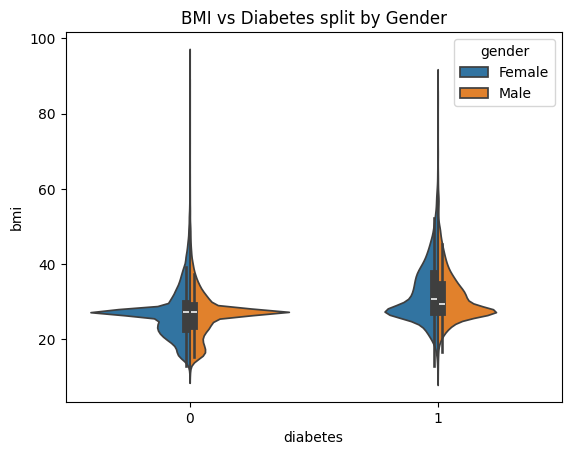

In [27]:
sns.violinplot(x='diabetes', y='bmi', hue='gender', split=True, data=df)
plt.title('BMI vs Diabetes split by Gender')
plt.show()

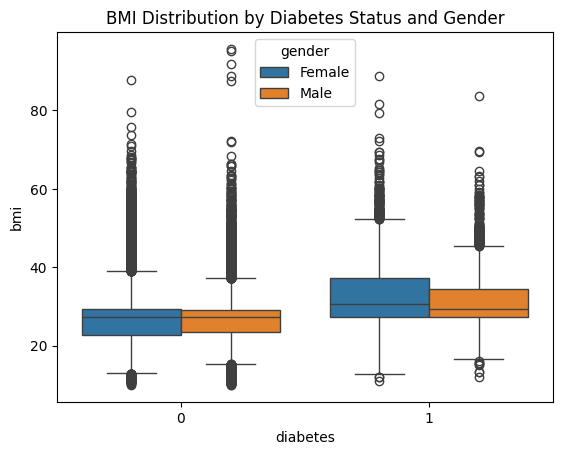

In [28]:
sns.boxplot(x='diabetes', y='bmi', hue='gender', data=df)
plt.title('BMI Distribution by Diabetes Status and Gender')
plt.show()

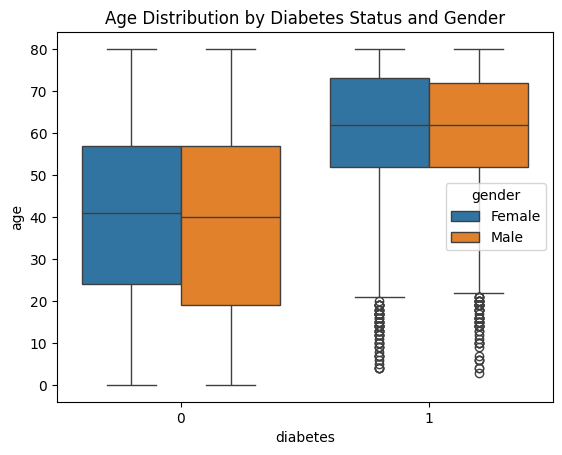

In [29]:
sns.boxplot(x='diabetes', y='age', hue='gender', data=df)
plt.title('Age Distribution by Diabetes Status and Gender')
plt.show()

In [30]:
# Create scalers
ss = StandardScaler()
# Columns
standard_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
# Apply StandardScaler
df_encoded[standard_cols] = ss.fit_transform(df_encoded[standard_cols])
df_encoded.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,1.692704,0,1,4,-0.321056,1.001706,0.047704,0
1,0,0.538006,0,0,0,-0.000116,1.001706,-1.426210,0
2,1,-0.616691,0,0,4,-0.000116,0.161108,0.489878,0
3,0,-0.261399,0,0,1,-0.583232,-0.492690,0.416183,0
4,1,1.515058,1,1,1,-1.081970,-0.679490,0.416183,0


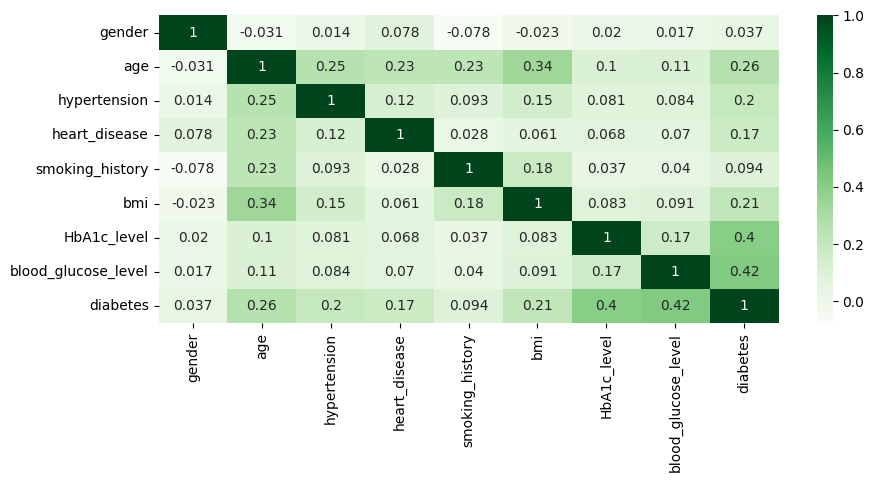

In [31]:
plt.figure(figsize = (10,4))
sns.heatmap(df_encoded.corr(),cmap = 'Greens',annot = True);

In [32]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

In [33]:
colors = ['#005E2C', '#4CAF50']

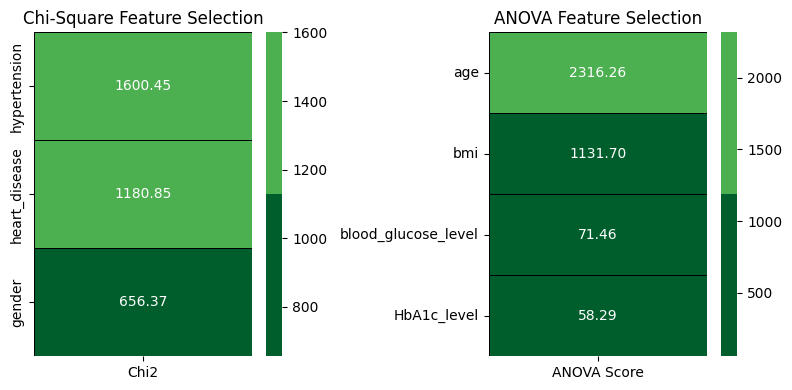

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# --- Chi-Square (categorical features) ---
chi_scores = SelectKBest(chi2, k='all').fit(
    df_encoded[categorical_features[:-1]],
    df_encoded[categorical_features[-1]]
).scores_

chi_df = pd.DataFrame(chi_scores, index=categorical_features[:-1], columns=["Chi2"])
sns.heatmap(
    chi_df.sort_values("Chi2", ascending=False),
    annot=True, cmap=colors, linewidths=.4, linecolor='black', fmt='.2f',
    ax=ax[0]
)
ax[0].set_title("Chi-Square Feature Selection")


# --- ANOVA (numerical features) ---
X = df_encoded[numerical_features]
y = df_encoded[categorical_features[-1]]

anova_scores = SelectKBest(f_classif, k='all').fit(X, y).scores_

anova_df = pd.DataFrame(anova_scores, index=numerical_features, columns=['ANOVA Score'])
sns.heatmap(
    anova_df.sort_values('ANOVA Score', ascending=False),
    annot=True, cmap=colors, linewidths=.4, linecolor='black', fmt='.2f',
    ax=ax[1]
)
ax[1].set_title("ANOVA Feature Selection")

plt.tight_layout()
plt.show()

In [35]:
# Splitting into full train and test
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)

# Splitting into train and test
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 42)

In [36]:
len(df_train), len(df_val), len(df_test)

(57676, 19226, 19226)

In [37]:
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)

In [38]:
y_train = df_train.diabetes.values
y_test = df_test.diabetes.values
y_val = df_val.diabetes.values

In [39]:
del df_train["diabetes"]
del df_test["diabetes"]
del df_val["diabetes"]

In [40]:
from sklearn.feature_extraction import DictVectorizer # for One-Hot Encoding

In [41]:
train_dicts = df_train.to_dict(orient = 'records')
One_Hot_encoder = DictVectorizer(sparse = False)
X_train = One_Hot_encoder.fit_transform(train_dicts)

In [42]:
val_dicts = df_val.to_dict(orient = 'records')
X_val = One_Hot_encoder.transform(val_dicts)

In [43]:
test_dicts = df_test.to_dict(orient = 'records')
X_test = One_Hot_encoder.transform(test_dicts)

In [44]:
One_Hot_encoder.get_feature_names_out()

array(['HbA1c_level', 'age', 'blood_glucose_level', 'bmi',
       'gender=Female', 'gender=Male', 'heart_disease', 'hypertension',
       'smoking_history=No Info', 'smoking_history=current',
       'smoking_history=ever', 'smoking_history=former',
       'smoking_history=never', 'smoking_history=not current'],
      dtype=object)

In [45]:
C_values = [0.01, 0.1, 1, 2, 10, 100]
c_param_scores = []
for param in C_values:
     model = LogisticRegression(solver = 'liblinear', C = param,
                               max_iter = 1000, random_state = 42)
     model.fit(X_train, y_train)
     y_pred = model.predict(X_val)
     Accuracy_score = 100 * (y_pred == y_val).mean()
     c_param_scores += [round(Accuracy_score, 2)]
Accuracy_score = pd.Series(c_param_scores, index = C_values, name = "parameters_scores")
Accuracy_score    

0.01      94.21
0.10      95.88
1.00      96.01
2.00      96.03
10.00     96.06
100.00    96.05
Name: parameters_scores, dtype: float64

In [46]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, 25, None]
for depth in depths: 
    dt = DecisionTreeClassifier(max_depth = depth, random_state = 42)
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_val)
    Accuracy_score = 100 * (y_pred == y_val).mean()
    print('Maximum depth: %4s -> Accuracy score: %.3f' % (depth, Accuracy_score))


Maximum depth:    1 -> Accuracy score: 95.350
Maximum depth:    2 -> Accuracy score: 97.197
Maximum depth:    3 -> Accuracy score: 97.197
Maximum depth:    4 -> Accuracy score: 97.197
Maximum depth:    5 -> Accuracy score: 97.197
Maximum depth:    6 -> Accuracy score: 97.197
Maximum depth:   10 -> Accuracy score: 97.139
Maximum depth:   15 -> Accuracy score: 96.505
Maximum depth:   20 -> Accuracy score: 95.652
Maximum depth:   25 -> Accuracy score: 95.137
Maximum depth: None -> Accuracy score: 95.132


In [47]:
scores = []
params = np.arange(10, 201, 10)
for d in [5, 10, 15, 20, 25]:
    for n in params:
        rf = RandomForestClassifier(n_estimators = n,
                                    max_depth = d,
                                    random_state = 42,
                                    n_jobs = -1)
        rf.fit(X_train, y_train)   #Training
        y_pred = rf.predict(X_val)   #Make predictions
        Accuracy_score = 100 * (y_pred == y_val).mean()  #Accuracy score
        scores.append((d, n, Accuracy_score))   #Parameters and accuracy score storage
columns = ['max_depth', 'n_estimators', 'Accuracy_score']   #column names
df_scores = pd.DataFrame(scores, columns = columns)
df_scores.groupby("max_depth")["Accuracy_score"].mean().round(3)

max_depth
5     97.197
10    97.200
15    97.156
20    97.066
25    96.989
Name: Accuracy_score, dtype: float64

In [48]:
max_depth = 10 #since, optimum depth is 10

In [49]:
scores = []
min_sampl = [1, 3, 5, 10, 50]
for s in min_sampl:
    for n in params:
        #initialize model
        rf = RandomForestClassifier(n_estimators = n,
                                    max_depth = 10,
                                    min_samples_leaf = s,
                                    random_state = 42,
                                    n_jobs = -1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        Accuracy_score = 100 * (y_pred == y_val).mean()  #Accuracy score
        scores.append((d, n, Accuracy_score))   #Parameters and accuracy score storage
columns = ['min_samples_leaf', 'n_estimators', 'Accuracy_score']   #column names
df_scores = pd.DataFrame(scores, columns = columns)
df_scores.sort_values(by = ["Accuracy_score", "n_estimators"], ascending = [False, True]).head(3)

,min_samples_leaf,n_estimators,Accuracy_score
3,25,40,97.212109
1,25,20,97.206907
21,25,20,97.206907


In [50]:
# Feature variables
features = list(One_Hot_encoder.get_feature_names_out())
# Wrap the training data into an optimized structure
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features)
# Wrap the validation data into an optimized structure
dval = xgb.DMatrix(X_val, label = y_val, feature_names = features)

# Dataset on which we want to iterate our model
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [51]:
eta_values = [0.1, 0.3, 0.5, 0.7, 0.9]
for eta_par in eta_values:
    # Model's parameters
    xgb_params = {
        'eta': eta_par, 
        'max_depth': 15,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }
    
    # Model training
    model = xgb.train(xgb_params, dtrain, 
                      num_boost_round = 200)
    
    # Make predictions
    y_pred = model.predict(dval) >= 0.5
    
    # Print parameter and accuracy score
    print('eta = %.1f, max_depth = 15, min_child_weight = 1, accuracy = %.3f.' % (xgb_params['eta'], (100 * (y_pred == y_val).mean())))

eta = 0.1, max_depth = 15, min_child_weight = 1, accuracy = 96.791.
eta = 0.3, max_depth = 15, min_child_weight = 1, accuracy = 96.588.
eta = 0.5, max_depth = 15, min_child_weight = 1, accuracy = 96.458.
eta = 0.7, max_depth = 15, min_child_weight = 1, accuracy = 96.448.
eta = 0.9, max_depth = 15, min_child_weight = 1, accuracy = 96.343.


In [52]:
eta_values = [0.1, 0.3, 0.5, 0.7, 0.9]

# XgBoost fine-tuning with learning rates
for eta_par in eta_values:
    # Model's parameters
    xgb_params = {
        'eta': eta_par, 
        'max_depth': 10,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }
    
    # Model training
    model = xgb.train(xgb_params, dtrain, 
                      num_boost_round = 200)
    
    # Make predictions
    y_pred = model.predict(dval) >= 0.5
    
    # Print parameter and accuracy score
    print('eta = %.1f, max_depth = 10, min_child_weight = 1, accuracy = %.3f.' % (xgb_params['eta'], (100 * (y_pred == y_val).mean())))

eta = 0.1, max_depth = 10, min_child_weight = 1, accuracy = 96.957.
eta = 0.3, max_depth = 10, min_child_weight = 1, accuracy = 96.650.
eta = 0.5, max_depth = 10, min_child_weight = 1, accuracy = 96.531.
eta = 0.7, max_depth = 10, min_child_weight = 1, accuracy = 96.338.
eta = 0.9, max_depth = 10, min_child_weight = 1, accuracy = 96.333.


In [53]:
def train(df_train, y_train, n_estimators = 40, max_depth = 10, min_samples_leaf = 25):
    train_dicts = df_train[categorical_features + numerical_features].to_dict(orient = 'records')
    
   
    One_Hot_encoder = DictVectorizer(sparse = False)    # Initialize One-Hot-Encoder (vectorizer)
                                                        # One-Hot-Encoder training and train data encoding
    X_train = One_Hot_encoder.fit_transform(train_dicts)

                                                        # Initialize random forest model
    rf = RandomForestClassifier(n_estimators = n_estimators,
                                max_depth = max_depth,
                                min_samples_leaf = min_samples_leaf,
                                random_state = 42,
                                n_jobs = -1)
    rf.fit(X_train, y_train)
    return One_Hot_encoder, rf
                                        # Function to make predictions with a random forest classifier
def predict(df, One_Hot_encoder, rf):
    dicts = df[categorical_features + numerical_features].to_dict(orient = 'records')

   
    X = One_Hot_encoder.transform(dicts)       # One-Hot-Encoding
                                            
    y_pred = rf.predict(X)                     # Make predictions 
    
    return y_pred
    

In [54]:
n_splits = 6

In [55]:
print(f"Performing KFold Cross-Validation")
kfold = KFold(n_splits = n_splits, shuffle = True, random_state = 1)
scores = []
fold = 0
for train_idx, val_idx in kfold.split(df_full_train):             # Select train and validation data
    
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    
    y_train = df_train.diabetes.values                              # Select target variables
    y_val = df_val.diabetes.values

                                                                  # Train model
    One_Hot_encoder, rf = train(df_train, y_train)
                                                                  # Make predictions
    y_pred = predict(df_val, One_Hot_encoder, rf)

    
    Accuracy_score = round(100 * (y_pred == y_val).mean(), 2)
    scores.append(Accuracy_score)
    print(f"Accuracy on fold {fold} is {Accuracy_score} %.")
                                                                   # Increment number of fold
    fold += 1
    
print("Validation results:")
print('Accuracy_score mean = %.2f, Accuracy_score std = +- %.2f' % (np.mean(scores), np.std(scores)))

Performing KFold Cross-Validation
Accuracy on fold 0 is 97.0 %.
Accuracy on fold 1 is 97.02 %.
Accuracy on fold 2 is 97.19 %.
Accuracy on fold 3 is 97.04 %.
Accuracy on fold 4 is 97.16 %.
Accuracy on fold 5 is 97.28 %.
Validation results:
Accuracy_score mean = 97.11, Accuracy_score std = +- 0.10


In [56]:
n_estimators, max_depth, min_samples_leaf = 40, 10, 1
One_Hot_encoder, rf = train(df_full_train[categorical_features + numerical_features], df_full_train.diabetes,
                            n_estimators = n_estimators, max_depth = max_depth,
                            min_samples_leaf = min_samples_leaf)
y_pred = predict(df_test, One_Hot_encoder, rf)
print('Optimal model accuracy = %.2f.' % (100 * (y_pred == y_test).mean()))

Optimal model accuracy = 96.92.


In [57]:
output_file = f'rf_model_{n_estimators}_trees_depth_{max_depth}_min_samples_leaf_{min_samples_leaf}.bin'
output_file

'rf_model_40_trees_depth_10_min_samples_leaf_1.bin'

In [58]:
with open(output_file, 'wb') as f_out:
    print("Storing the model into a file")
    pickle.dump((One_Hot_encoder, rf), f_out)
    
print(f"The model is saved to {output_file}.")

Storing the model into a file
The model is saved to rf_model_40_trees_depth_10_min_samples_leaf_1.bin.


In [59]:
!ls *bin

rf_model_40_trees_depth_10_min_samples_leaf_1.bin


In [60]:
input_file = 'rf_model_40_trees_depth_10_min_samples_leaf_1.bin'
with open(input_file, 'rb') as f_in:
    One_Hot_encoder, rf = pickle.load(f_in)

rf

RandomForestClassifier(max_depth=10, n_estimators=40, n_jobs=-1,
                       random_state=42)

In [61]:
patient = {
    "gender": "Male",
    "age": "56",                         
    "hypertension": 0,              
    "heart_disease": 1,                    
    "smoking_history": "never",                  
    "bmi": 23.19,                     
    "HbA1c_level": 5.30,                  
    "blood_glucose_level": 103,                        
}

In [62]:
X_i = pd.DataFrame([patient])
y_i_pred = predict(X_i, One_Hot_encoder, rf)
print('input data:')
display(X_i)
print('output information:', y_i_pred)
if y_i_pred[0]:
    print('Define a treatment for the patient-test.')

input data:


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,Male,56,0,1,never,23.19,5.3,103


output information: [0]
